# Forschungsfrage

### Wie zuverlässig lassen sich Hassrede, Beleidigungen und neutrale Sprache in sozialen Medien mit klassischen ML-Algorithmen und  modernen Transformer-Modellen erkennen?

## Datenset
https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset

## Herangehensweise
Als erstes wollen wir herkömmliche ML-Algortihmen evaluieren, um ein Gefühl für die durchschnittliche Performance mit diesem Datensetz zu bekommen. Anschließend verwenden wir dann ein pretrained-Transformer-Model "distilbert-base-uncased" und trainieren es anhand unserer Train-Daten.

## 1. Data Exploration

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import joblib
import re
import seaborn as sns
import nltk
import torch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from datasets import Dataset, ClassLabel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, TextClassificationPipeline 

In [3]:
# NLTK-Ressourcen für Tokenisierung und Stopwords herunterladen (nur beim ersten mal nötig)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Philipp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Philipp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df = pd.read_csv("labeled_data.csv")
df.head(20)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


In [5]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783
unique,NaN,NaN,NaN,NaN,NaN,NaN,24783
top,NaN,NaN,NaN,NaN,NaN,NaN,~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
freq,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277,NaN
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089,NaN
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000,NaN
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000,NaN
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000,NaN


In [6]:
df['class'].value_counts()

class
1    19190
2     4163
0     1430
Name: count, dtype: int64

## 2. Data Preperation

In diesem Abschnitt `bereinigen` wir die Tweets, indem wir:
- Kleinbuchstaben erzwingen
- URLs, Mentions und Sonderzeichen entfernen
- Stopwords eliminieren

In [7]:
# Bereinigen des Texts (Lowercase, URLs, Mentions, Sonderzeichen)
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)         # URLs entfernen
    text = re.sub(r"@\w+", "", text)            # Mentions entfernen
    text = re.sub(r"[^a-z\s]", "", text)        # Sonderzeichen entfernen
    return text

# Bereinigte Texte in neuer Spalte speichern
df['cleaned_text'] = df['tweet'].astype(str).apply(clean_text)
df[['tweet', 'cleaned_text']].head(10) # Original vs. bereinigt


,tweet,cleaned_text
0,!!! RT @mayasolovely: As a woman you shouldn't...,rt as a woman you shouldnt complain about cl...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt boy dats coldtyga dwn bad for cuffin dat ...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt dawg rt you ever fuck a bitch and she st...
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt she look like a tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt the shit you hear about me might be true ...
5,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",the shit just blows meclaim you so faithful a...
6,"!!!!!!""@__BrighterDays: I can not just sit up ...",i can not just sit up and hate on another bit...
7,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,cause im tired of you big bitches coming for ...
8,""" &amp; you might not get ya bitch back &amp; ...",amp you might not get ya bitch back amp thats...
9,""" @rhythmixx_ :hobbies include: fighting Maria...",hobbies include fighting mariam\r\n\r\nbitch


In [8]:
# Englische Stopwords laden
stop_words = set(stopwords.words('english'))

# Tokenisieren und Entfernen von Stopwords
def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text, preserve_line=True)
    filtered = [word for word in tokens if word not in stop_words]
    return " ".join(filtered)

# SNeue Spalte mit stopword-bereinigtem Text
df['processed_text'] = df['cleaned_text'].apply(tokenize_and_remove_stopwords)
df[['cleaned_text', 'processed_text']].head() # Cleaned vs. Final Preprocessed


,cleaned_text,processed_text
0,rt as a woman you shouldnt complain about cl...,rt woman shouldnt complain cleaning house amp ...
1,rt boy dats coldtyga dwn bad for cuffin dat ...,rt boy dats coldtyga dwn bad cuffin dat hoe st...
2,rt dawg rt you ever fuck a bitch and she st...,rt dawg rt ever fuck bitch start cry confused ...
3,rt she look like a tranny,rt look like tranny
4,rt the shit you hear about me might be true ...,rt shit hear might true might faker bitch told ya


## Label-Mapping

Zur besseren Lesbarkeit der Zielvariablen werden die numerischen Klassen (`0`, `1`, `2`) in beschreibende Labels umgewandelt:
- 0 -> Hate Speech
- 1 -> Offensive Language
- 2 -> Neither


In [9]:
label_mapping = {
    0: 'Hate Speech',
    1: 'Offensive Language',
    2: 'Neither'
}

df['label'] = df['class'].map(label_mapping)

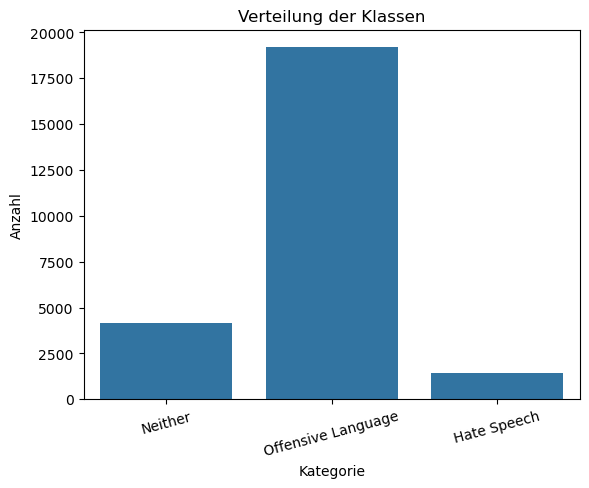

In [10]:
sns.countplot(data=df, x='label')
plt.title("Verteilung der Klassen")
plt.xlabel("Kategorie")
plt.ylabel("Anzahl")
plt.xticks(rotation=15)
plt.show()

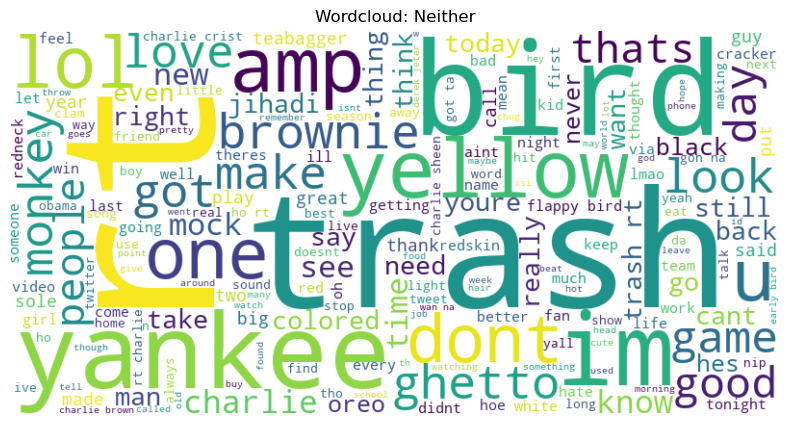

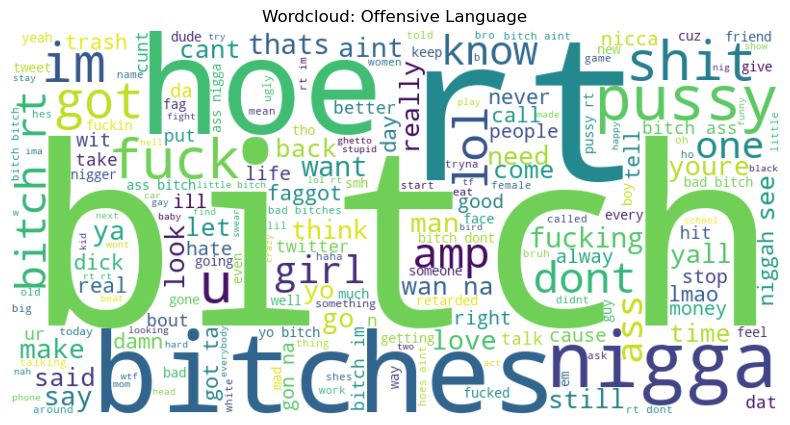

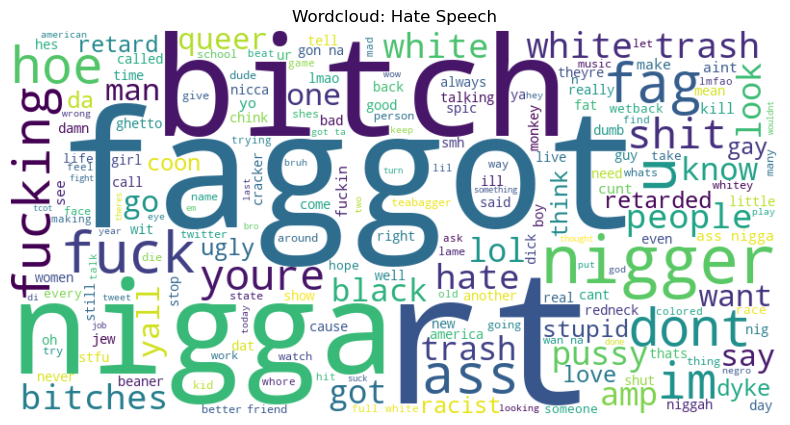

In [11]:
# Erzeugen und Anzeigen einer Wordcloud aus Texten
def show_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

for label in df['label'].unique(): # # Für jede Textklasse eine eigene Wordcloud anzeigen
    subset = df[df['label'] == label]
    show_wordcloud(subset['processed_text'], f"Wordcloud: {label}")


## 3. Statistische und herkömmliche ML-Algorithmen

Im nächsten Schritt vergleichen wir verschiedene klassische Machine-Learning-Modelle auf unserem Textklassifikationsproblem.

Dabei gehen wir wie folgt vor:

- **Text-Vektorisierung** über TF-IDF mit Wort- und Bigrammen
- **Train/Test-Split** der Daten (stratifiziert oder mit fester Zufallszahl)
- **Trainieren mehrerer Modelle:**
  - Logistische Regression
  - Naive Bayes
  - Support Vector Machine (SVM)
  - Random Forest Classifier
  - Gradient Boosting Classifier
--------------------------------------------------------------------------------------
- **Evaluation** der Modelle anhand von:
  - Accuracy
  - F1-Score (macro)
  - Confusion Matrix
  - Classification Report pro Klasse

Ziel ist es, die Performance und Stärken/Schwächen der Modelle zu vergleichen – besonders im Umgang mit unbalancierten Klassen wie "Hate Speech".


In [13]:
X = df['processed_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# TF-IDF + Klassifikation
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Training
pipeline.fit(X_train, y_train)

# Prediction
y_pred = pipeline.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

Classification Report:

                    precision    recall  f1-score   support

       Hate Speech       0.32      0.62      0.42       286
           Neither       0.76      0.94      0.84       833
Offensive Language       0.97      0.85      0.91      3838

          accuracy                           0.85      4957
         macro avg       0.68      0.80      0.72      4957
      weighted avg       0.90      0.85      0.87      4957

Confusion Matrix:

[[ 177   31   78]
 [  23  783   27]
 [ 354  212 3272]]


In [20]:
X = df["processed_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Klassische ML-Modelle definieren
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000, class_weight='balanced')),
    ("Naive Bayes", MultinomialNB()),
    ("Linear SVM", LinearSVC(class_weight='balanced'))
]

results = [] # Speichern der Modellnamen + Accuracy + F1-Macro

for name, model in models:
    print(f"\n Testing model: {name}")

    # TF-IDF-Vektorisierung + Klassifikator
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ('clf', model)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Code um trainierte models zu speichern
    #filename = name.lower().replace(" ", "_") + "_model.pkl"
    #joblib.dump(pipe, f"ExportModels/{filename}")
    #print(f"💾 Modell gespeichert unter: ExportModels/{filename}")
    
    results.append((name, acc, f1_macro))


 Testing model: Logistic Regression
Classification Report:
                    precision    recall  f1-score   support

       Hate Speech       0.32      0.62      0.42       286
           Neither       0.76      0.94      0.84       833
Offensive Language       0.97      0.85      0.91      3838

          accuracy                           0.85      4957
         macro avg       0.68      0.80      0.72      4957
      weighted avg       0.90      0.85      0.87      4957

💾 Modell gespeichert unter: ExportModels/logistic_regression_model.pkl

 Testing model: Naive Bayes
Classification Report:
                    precision    recall  f1-score   support

       Hate Speech       1.00      0.01      0.02       286
           Neither       0.90      0.49      0.64       833
Offensive Language       0.85      0.99      0.91      3838

          accuracy                           0.85      4957
         macro avg       0.91      0.50      0.52      4957
      weighted avg       0.86   


 Vergleich der Modelle:


,Model,Accuracy,F1_macro
0,Logistic Regression,0.853742,0.723605
1,Naive Bayes,0.850514,0.522986
2,Linear SVM,0.877950,0.718061


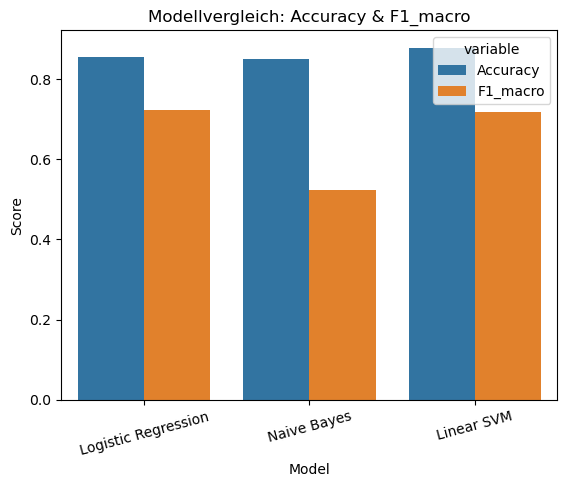

In [21]:
# Vergleiche der Modelle
df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "F1_macro"])
print("\n Vergleich der Modelle:")
display(df_results)

sns.barplot(data=df_results.melt(id_vars="Model"), x="Model", y="value", hue="variable")
plt.title("Modellvergleich: Accuracy & F1_macro")
plt.ylabel("Score")
plt.xticks(rotation=15)
plt.show()

In [23]:
# Features & Target
X = df["cleaned_text"]
y = df["label"]  # Originalklasse (0 = hate speech, 1 = offensive, 2 = neither)

# Text-Vektorisierung (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_vectorized = vectorizer.fit_transform(X)

# Train/Test-Split
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=9)

# Random Forest
model = RandomForestClassifier(random_state=9)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Code für model speichern
#joblib.dump(model, "ExportModels/random_forest_model.pkl")
#print("Random Forest Modell gespeichert.")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Random Forest Modell gespeichert.
Accuracy: 0.8829937462174703
Confusion Matrix:
 [[  30   21  225]
 [   3  624  180]
 [  31  120 3723]]
Classification Report:
                     precision    recall  f1-score   support

       Hate Speech       0.47      0.11      0.18       276
           Neither       0.82      0.77      0.79       807
Offensive Language       0.90      0.96      0.93      3874

          accuracy                           0.88      4957
         macro avg       0.73      0.61      0.63      4957
      weighted avg       0.86      0.88      0.87      4957



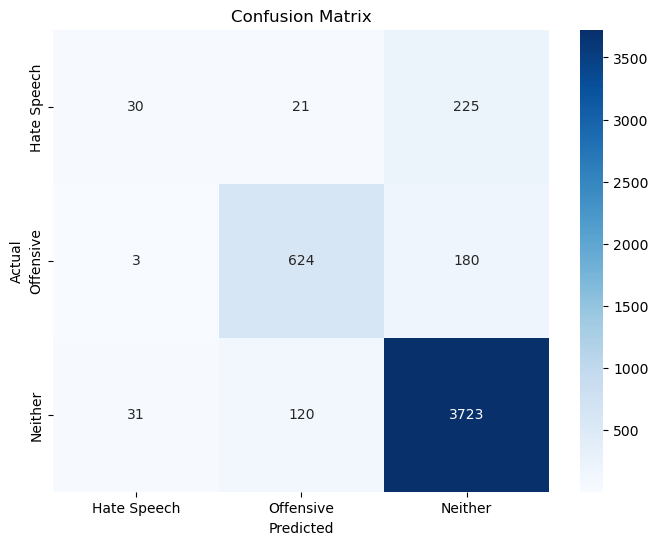

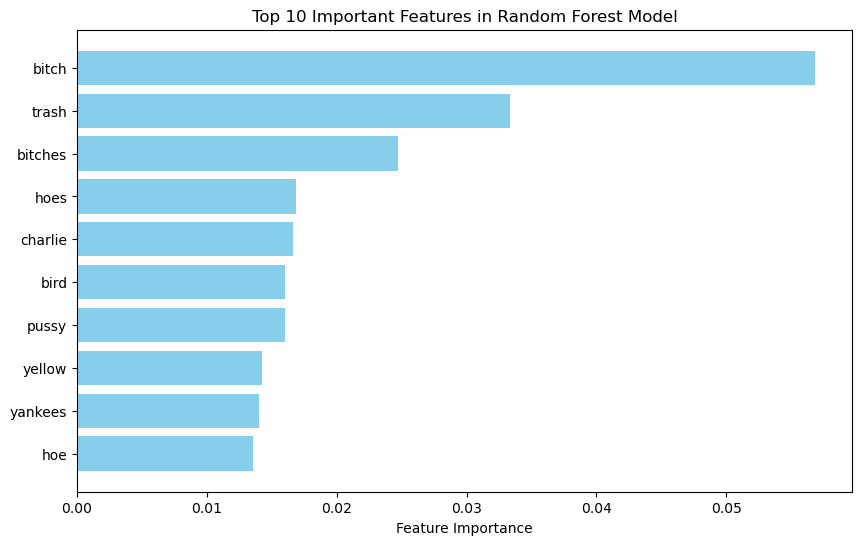

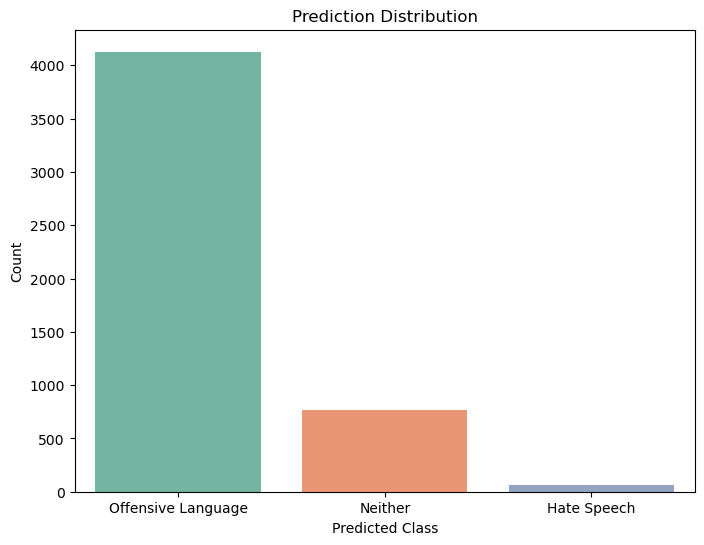

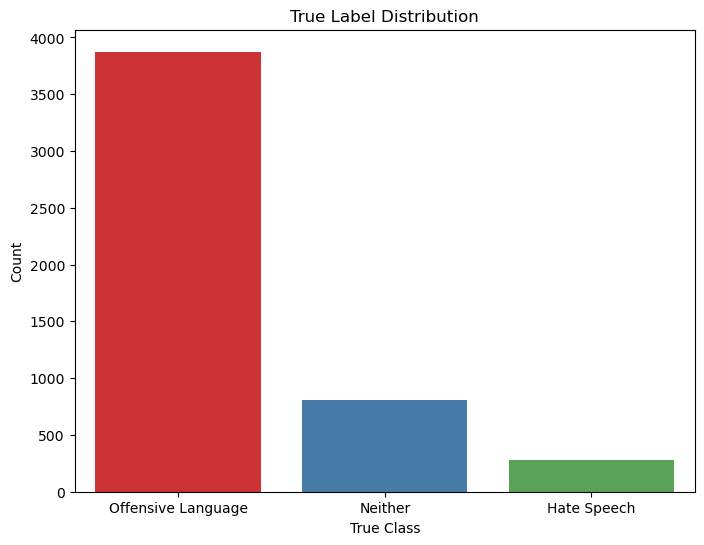

In [38]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Hate Speech", "Offensive", "Neither"], yticklabels=["Hate Speech", "Offensive", "Neither"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature-Wichtigkeit
importances = model.feature_importances_
indices = importances.argsort()[-10:][::-1]
top_features = [vectorizer.get_feature_names_out()[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.barh(top_features, importances[indices], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features in Random Forest Model")
plt.gca().invert_yaxis()
plt.show()

# Vorhersagen
plt.figure(figsize=(8, 6))
sns.countplot(x=y_pred, palette="Set2", hue=y_pred)
plt.title("Prediction Distribution")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.show()

# Tatsächlichen Labels
plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, palette="Set1", hue=y_test)
plt.title("True Label Distribution")
plt.xlabel("True Class")
plt.ylabel("Count")
plt.show()

In [24]:
X = df["cleaned_text"]
y = df["label"]

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_vectorized = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=9)

# Gradient Boosting
model = GradientBoostingClassifier(random_state=9)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Code fürs speichern des models
#joblib.dump(model, "ExportModels/gradient_boosting_model.pkl")
#print("Gradient Boosting Modell gespeichert.")

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

✅ Gradient Boosting Modell gespeichert.
Accuracy: 0.8725035303611055
Confusion Matrix:
 [[  71   12  193]
 [   3  518  286]
 [  53   85 3736]]
Classification Report:
                     precision    recall  f1-score   support

       Hate Speech       0.56      0.26      0.35       276
           Neither       0.84      0.64      0.73       807
Offensive Language       0.89      0.96      0.92      3874

          accuracy                           0.87      4957
         macro avg       0.76      0.62      0.67      4957
      weighted avg       0.86      0.87      0.86      4957



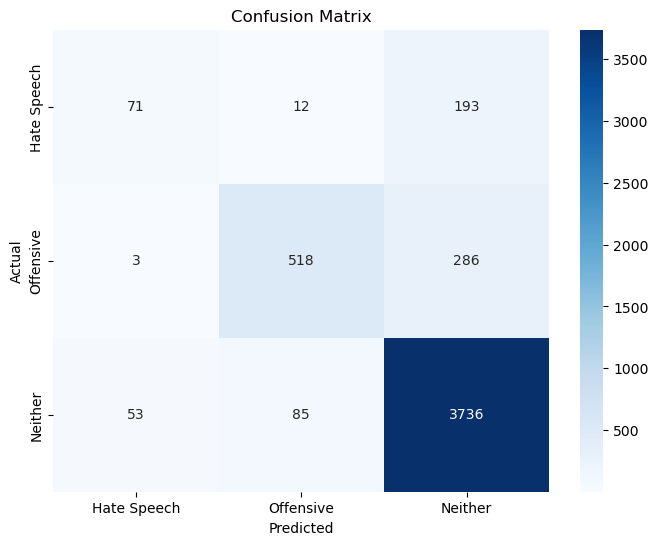

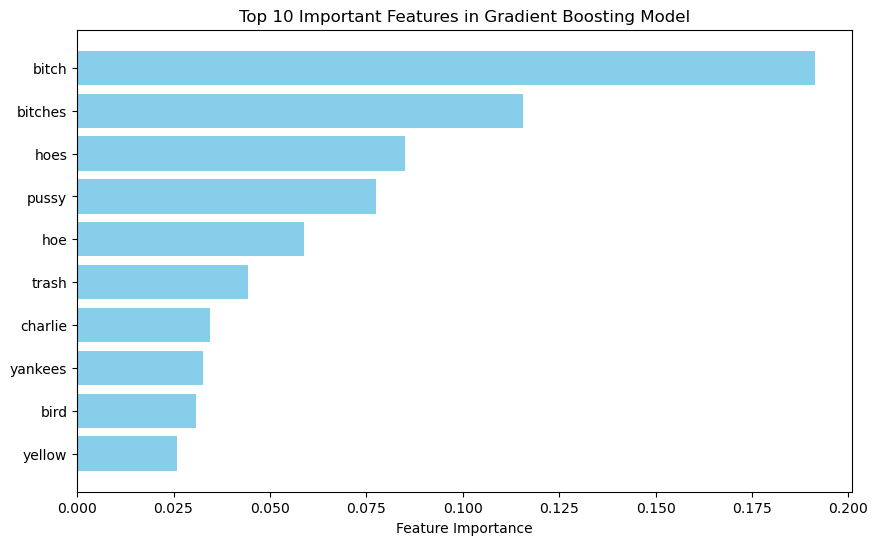

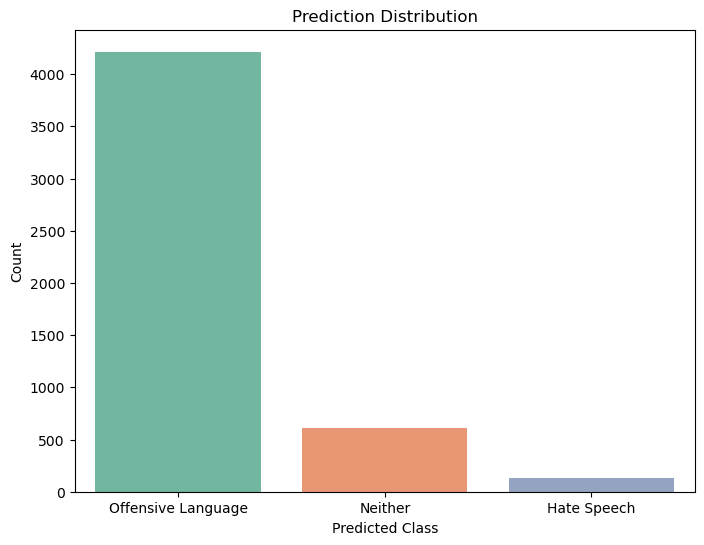

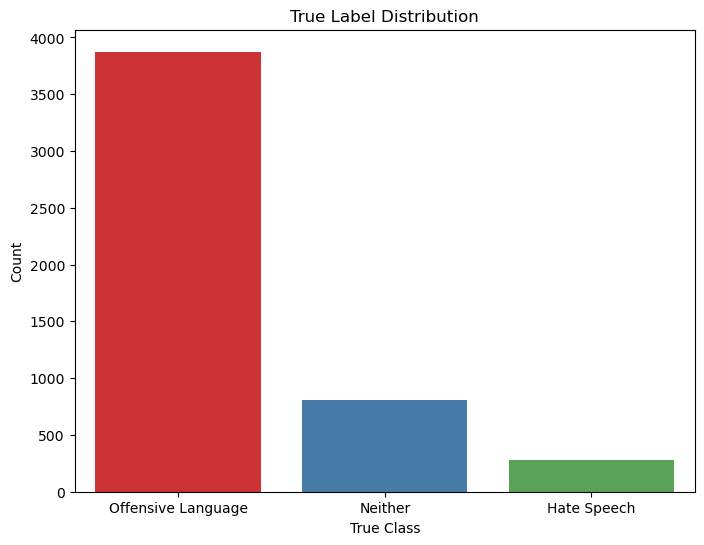

In [40]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Hate Speech", "Offensive", "Neither"], yticklabels=["Hate Speech", "Offensive", "Neither"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature-Wichtigkeit
importances = model.feature_importances_
indices = importances.argsort()[-10:][::-1]
top_features = [vectorizer.get_feature_names_out()[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.barh(top_features, importances[indices], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features in Gradient Boosting Model")
plt.gca().invert_yaxis()
plt.show()

# Vorhersagen
plt.figure(figsize=(8, 6))
sns.countplot(x=y_pred, palette="Set2", hue=y_pred)
plt.title("Prediction Distribution")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.show()

# Tatsächlichen Labels
plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, palette="Set1", hue=y_test)
plt.title("True Label Distribution")
plt.xlabel("True Class")
plt.ylabel("Count")
plt.show()

## 4. Transformer-Modelle

Wir vergleichen klassische ML-Methoden mit modernen, vortrainierten Sprachmodellen.  
Ziel ist es, herauszufinden, ob der zusätzliche Rechenaufwand durch höhere Genauigkeit gerechtfertigt ist.

In diesem Abschnitt verwenden wir das Modell **DistilBERT** und feintunen es auf unser Klassifikationsproblem:
- Tokenisierung mit Hugging Face
- Fine-Tuning von `distilbert-base-uncased`
- Trainingsüberwachung mit `Trainer`
- Evaluation anhand Accuracy und F1-Score


In [36]:
# Nur die nötigen Spalten auswählen
df_model = df[["processed_text", "label"]].dropna()

# Klassennamen in numerische IDs umwandeln
label2id = {"Hate Speech": 0, "Offensive Language": 1, "Neither": 2}
id2label = {v: k for k, v in label2id.items()}
df_model["label_id"] = df_model["label"].map(label2id)

# In Hugging Face Dataset konvertieren
dataset = Dataset.from_pandas(df_model[["processed_text", "label_id"]])

# Spalte explizit als ClassLabel definieren
features = dataset.features.copy()
features["label_id"] = ClassLabel(num_classes=3, names=["Hate Speech", "Offensive Language", "Neither"])
dataset = dataset.cast(features)

# Stratified Train/Test-Split
dataset = dataset.train_test_split(test_size=0.2, stratify_by_column="label_id")


Casting the dataset:   0%|          | 0/24783 [00:00<?, ? examples/s]

In [37]:
# Modell & Tokenizer laden (DistilBERT)
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Tokenizer-Funktion für den Datensatz
def tokenize_function(example):
    return tokenizer(example["processed_text"], truncation=True, padding="max_length", max_length=128)

# Tokenisierung anwenden (batched für Geschwindigkeit)
tokenized_datasets = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/19826 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

In [38]:
# Klassifikationsmodell laden (mit Klassenzahl & Label-Mapping)
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
# CUDA-Verfügbarkeit prüfen (für GPU-Training)
print('Cuda available: ', torch.cuda.is_available())
print('torch version: ', torch.__version__)
if torch.cuda.is_available():
    # Get the CUDA version
    cuda_version = torch.version.cuda
    print(f"CUDA version: ", cuda_version)

Cuda available:  False
torch version:  2.6.0+cpu


In [ ]:
# Berechnung der Metriken
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }

# Trainingsparameter
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
)

tokenized_datasets = tokenized_datasets.rename_column("label_id", "labels")

# Padding-Collator verwenden (füllt Text automatisch auf gleiche Länge)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Hugging Face Trainer initialisieren
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


In [41]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.256000,0.272349,0.900545,0.749787
2,0.231900,0.248184,0.911438,0.672287
3,0.177700,0.254294,0.909623,0.760206
4,0.136800,0.284298,0.907404,0.719750
5,0.115000,0.291105,0.908211,0.750173


TrainOutput(global_step=775, training_loss=0.19957372726932648, metrics={'train_runtime': 282.0535, 'train_samples_per_second': 351.458, 'train_steps_per_second': 2.748, 'total_flos': 3282931852577280.0, 'train_loss': 0.19957372726932648, 'epoch': 5.0})

In [42]:
# Evaluation (eval_loss, eval_accuracy, f1_macro etc.)
metrics = trainer.evaluate()
print(metrics)

# Classification Report
predictions = trainer.predict(tokenized_datasets["test"])
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=1)
print(classification_report(y_true, y_pred, target_names=label2id.keys()))


{'eval_loss': 0.24818408489227295, 'eval_accuracy': 0.9114383699818439, 'eval_f1_macro': 0.6722869436819515, 'eval_runtime': 4.911, 'eval_samples_per_second': 1009.369, 'eval_steps_per_second': 7.941, 'epoch': 5.0}
                    precision    recall  f1-score   support

       Hate Speech       0.56      0.11      0.18       286
Offensive Language       0.93      0.97      0.95      3838
           Neither       0.86      0.91      0.89       833

          accuracy                           0.91      4957
         macro avg       0.78      0.66      0.67      4957
      weighted avg       0.90      0.91      0.89      4957



## 5. Transformer-Modell für Hate Speech (nicht von uns trainiert)

In diesem Abschnitt testen wir ein bereits vortrainiertes Transformer-Modell für Hate Speech Detection:

- Modell: `Hate-speech-CNERG/dehatebert-mono-english`  
- Quelle: Hugging Face  
- Ziel: Nutzen der bereits trainierten Pipeline, um Klassifizierungen auf unseren Tweets durchzuführen  
- Das Modell gibt Scores für mehrere Klassen zurück (hier: "Hate Speech" vs. "Not Hate Speech")

Wir verwenden `TextClassificationPipeline` von Hugging Face, um die Klassifikation auszuführen, und analysieren die Prediction Scores sowie die finale Accuracy und F1-Werte.


In [44]:
file_path = "labeled_data.csv"
df = pd.read_csv(file_path)

# Tweets bereinigen (gleiche clean_text-Funktion wie zuvor)
df["clean_tweet"] = df["tweet"].apply(clean_text)

In [47]:
# Vortrainiertes Hate-Speech-Modell von Hugging Face
model_name = "Hate-speech-CNERG/dehatebert-mono-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Klassifikationspipeline mit Rückgabe aller Scores
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

# Vorhersage für jeden Tweet (einzeln, daher langsamer)
df["hate_speech_score"] = df["clean_tweet"].apply(lambda x: pipe(x)[0])

Device set to use cuda:0
C:\Users\David\miniconda3\envs\myenv_nlp\lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [48]:
# Einzelne Scores extrahieren
df["label_0_score"] = df["hate_speech_score"].apply(lambda x: x[0]["score"])
df["label_1_score"] = df["hate_speech_score"].apply(lambda x: x[1]["score"])

# Höchsten Score auswählen → als vorhergesagtes Label
df["predicted_label"] = df[["label_0_score", "label_1_score"]].idxmax(axis=1).map({
    "label_0_score": "Not Hate Speech",
    "label_1_score": "Hate Speech"
})

# Original-Label als binary (Hate Speech = 1, Rest = 0)
df["binary_class"] = df["class"].apply(lambda x: 1 if x in [0, 1] else 0)

# Vorhersage und wahre Labels binär umwandeln für die Berechnung der Accuracy
y_true = df["binary_class"]
y_pred = df["predicted_label"].map({"Hate Speech": 1, "Not Hate Speech": 0})

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8311745954888432


C:\Users\David\AppData\Local\Temp\ipykernel_22176\1012335360.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="predicted_label", palette="Set2")


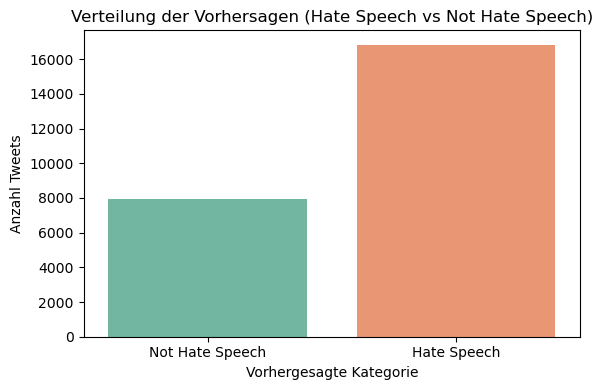

In [49]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="predicted_label", palette="Set2", hue="predicted_label")
plt.title("Verteilung der Vorhersagen (Hate Speech vs Not Hate Speech)")
plt.xlabel("Vorhergesagte Kategorie")
plt.ylabel("Anzahl Tweets")
plt.tight_layout()
plt.show()

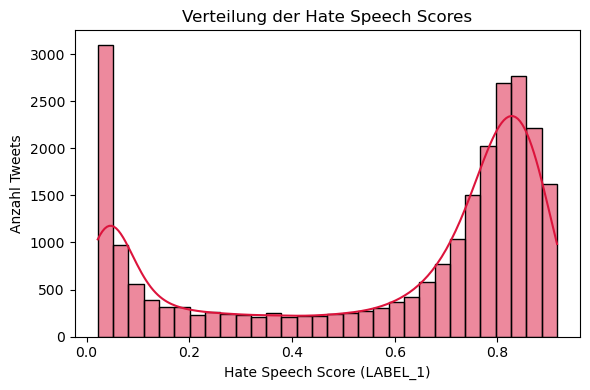

In [50]:
plt.figure(figsize=(6,4))
sns.histplot(df["label_1_score"], bins=30, kde=True, color="crimson")
plt.title("Verteilung der Hate Speech Scores")
plt.xlabel("Hate Speech Score (LABEL_1)")
plt.ylabel("Anzahl Tweets")
plt.tight_layout()
plt.show()

C:\Users\David\AppData\Local\Temp\ipykernel_22176\3436895414.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="predicted_label", y="label_1_score", palette="coolwarm")


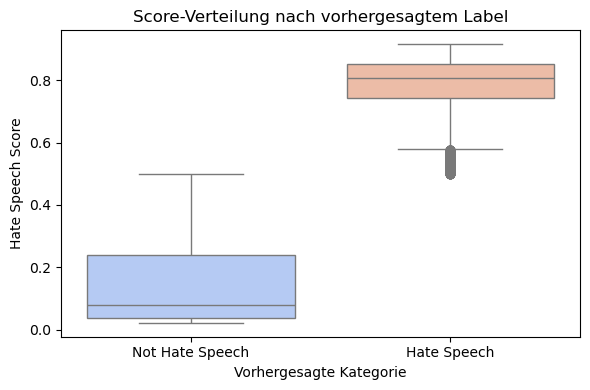

In [51]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="predicted_label", y="label_1_score", palette="coolwarm", hue="predicted_label")
plt.title("Score-Verteilung nach vorhergesagtem Label")
plt.xlabel("Vorhergesagte Kategorie")
plt.ylabel("Hate Speech Score")
plt.tight_layout()
plt.show()

In [52]:
# Die stärksten Hate-Speech-Klassifizierungen anzeigen
top_hate = df.sort_values(by="label_1_score", ascending=False).head(10)
print(top_hate[["tweet", "label_1_score", "predicted_label"]])

                                                   tweet  label_1_score  \
6107                        @i2ose is it full of niggers       0.916127   
4822   @THERACISTDOCTOR One less little nigger that w...       0.916031   
5358            @_TriggaPlease_ @kanyewest he's a faggot       0.915817   
2458   @Ant_Dgk @Buckm00se @ChainskiBum would this fa...       0.914594   
21535     The blacks in #California are typical niggers.       0.914588   
5716                    @chanelisabeth that nigger music       0.914154   
5829      @delaney_guinan a faggot that needs to grow up       0.914092   
6229                            @jayswaggkillah Is a fag       0.913568   
6230                            @jayswaggkillah is a fag       0.913568   
4512                 @RedNationBlogga fuck those faggots       0.913514   

      predicted_label  
6107      Hate Speech  
4822      Hate Speech  
5358      Hate Speech  
2458      Hate Speech  
21535     Hate Speech  
5716      Hate Speech  
5829  

In [53]:
# Classification Report
print("Classification Report:\n", classification_report(y_pred, y_true))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.50      0.65      7959
           1       0.81      0.99      0.89     16824

    accuracy                           0.83     24783
   macro avg       0.88      0.74      0.77     24783
weighted avg       0.85      0.83      0.81     24783

